# Reproducing Figure 1 from "The Quantum Alternating Operator Ansatz on Maximum $\textit{k}$-Vertex Cover" Using JuliQAOA


**Disclaimer: This is not meant to be a professional document, given the number of lengthy comments, print statements, potential typos, and (massively) quoted material. I also assume some understanding of the main ingredients of QAOA. So my notation may not be very consistent and the ordering of topics may not always make sense. Viewer discretion is advised.**

In this notebook, I will aim to reproduce Figure 1 from [arXiv:1910.13483](https://arxiv.org/abs/1910.13483). In the latter the authors present approximation ratios using either the complete graph mixer or the ring mixer.


**Note:** The most important elements in this notebook can be found in [JuliQAOA's Constrained MaxCut example](https://github.com/lanl/JuliQAOA.jl/blob/main/examples/maxcut_kconst.ipynb). While we are considering the maximum k-vertex cover problem here, the most important change is the cost function. This notebook was essentially a way for me to practice with Julia and QAOA.


In [1]:
using JuliQAOA
#using Random
using Statistics # for mean function
using Graphs, GraphRecipes, Plots # for graph visualizations
#using Pyplot, Colors, ColorSchemes # for nice color schemes
using LinearAlgebra # for norm

#Random.seed!(1);

## 1. Initial States


We need to consider two types of initial states: Dicke states and random $k$-states, $k$ referring to the Hamming weight. We also need to consider the number of qubits $n$ involved in the states. Recall that an $n$-qubit state means a vector representation with size $2^n$, as it results from the tensor product of individual two-state systems (qubits). We will be using graphs that have between $n = 7$ and $n = 10$ vertices as in [arXiv:1910.13483](https://arxiv.org/abs/1910.13483). Below are two functions allowing one to select specific states with a specific Hamming weight and order states by Hamming weights. These functions are ultimately unnecessary when it comes to [arXiv:1910.13483's](https://arxiv.org/abs/1910.13483) Figure 1, as all random-$k$ states are considered (to create confidence intervals). The same is true for Dicke states, as their individual components take $k$ as a parameter.


### a) Random $k$-States


In [2]:
function khw_n_states(n::Int, k::Int)
    """
    Produces an array of n-qubit states with hamming weight k. Technically, all the states are
    available in states(n).
    --- Inputs: n: number of qubits in the state
                k: Hamming weight
    --- Outputs: nk_state_array: array of qubits of size n and Hamming weight k
    Note: We could also very well have used Dicke states
    """
    nk_state_array = Vector{Int64}[]
    for x in states(n)
        if sum(x) == k # x is an array with 1s and 0s, the sum of 1s gives the Hamming weight
            push!(nk_state_array, x) # push! instead of append! as the two arguments are different types
                                     # ! convention when functions modify their arguments
            #println(join(repr.(nk_state_array),", "))
        end
    end
    return nk_state_array
end



function kord_n_states(n::Int)
    """
    Produces an array n-qubit states with hamming weights between 0 and n. Technically, all the states are
    available in states(n). What we are doing here is ordering states by Hamming weight,
    as in 1910.13483.
    --- Inputs: k: Hamming weight
                n: number of qubits in the state
    --- Outputs: array of qubits of size n and Hamming weight k
    """

    n_state_array = []
    for k = 0:n
        push!(n_state_array, khw_n_states(n_test, k))
        #println(n_state_array)
        #println(join(repr.(n_state_array)),", ")
    end
    #for state in n_state_array[1]
    #println(state)
    #println(n_state_array[[2,1]])
    #@show n_state_array
    return n_state_array
end

kord_n_states (generic function with 1 method)

### b) Dicke States


These are accessible in [JuliQAOA](https://lanl.github.io/JuliQAOA.jl/dev/utils/#JuliQAOA.dicke_states-Tuple{Any,%20Any}) by calling `dicke_states(n,k)`. In JuliQAOA, `dicke_states(n, k)` corresponds to a DickeIterator object which "[i]terate[s] over all $n$-bit binary arrays with exactly $k$ 1's" (see [JuliQAOA Github](https://github.com/lanl/JuliQAOA.jl/blob/main/src/utils.jl)). So the function is really used to iterate over states of Hamming weight $k$ and select the state that leads to the optimal cost.


## 2. Producing Random Graphs


SimpleGraph{Int64}(21, [[2, 3, 4, 5, 6, 7], [1, 3, 4, 5, 6, 7], [1, 2, 4, 5, 6, 7], [1, 2, 3, 5, 6, 7], [1, 2, 3, 4, 6, 7], [1, 2, 3, 4, 5, 7], [1, 2, 3, 4, 5, 6]])

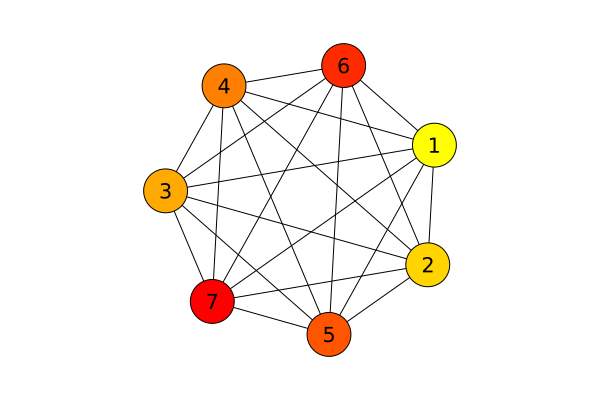

In [3]:
# Most of this is from https://docs.juliaplots.org/stable/GraphRecipes/examples/

# using GraphRecipes, Plots

n_test = 7
g = erdos_renyi(n_test, 0.99) # Below 0.5 makes it more likely to have a disconnected graph
print(g) # outputs: Object{type}(number of edges, adjacency list)
graphplot(g, nodeshape=:circle, names=1:n_test, fontsize = 14, 
             markersize = 0.2, 
             markercolor = range(colorant"yellow", stop=colorant"red", length=n_test), 
             curves=false)

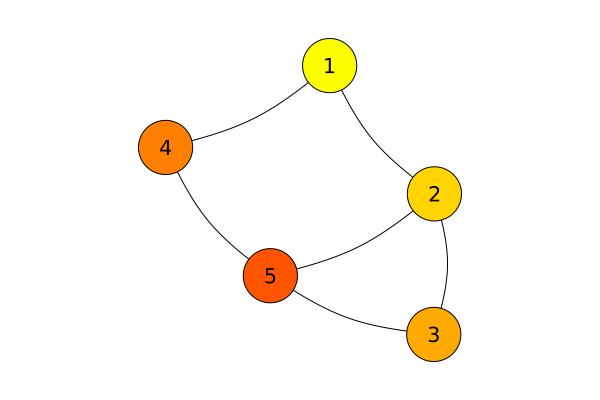

In [4]:
# This is just to show how maxcut works. Most of this is from https://lanl.github.io/JuliQAOA.jl/dev/cost_funcs/

# using GraphRecipes, Plots
# using JuliQAOA, Graphs

g = SimpleGraph(5)

edges = [(1,2), (1,4), (2,3), (2,5), (3,5), (4,5)];

for edge in edges
    add_edge!(g, edge[1], edge[2])
end

maxcut(g, [0, 0, 1, 1, 1])

weights = Dict((1,2)=>4,(1,4)=>2,(2,3)=>1,(2,5)=>3,(3,5)=>3,(4,5)=>1);

maxcut(g, [0, 1, 0, 0, 1]; weights=weights)

graphplot(g, nodeshape=:circle, names=1:n_test, fontsize = 14, 
             markersize = 0.2, 
             markercolor = range(colorant"yellow", stop=colorant"red", length=n_test), 
             curves=true)

In [5]:
#using Graphs

function graph_array(n_min::Int, n_max::Int, num_graph::Int, p::Real)
    """
    Creates a list of Erdos-Renyi random graphs with number of vertices between n_min and n_max vertices.
    --- Inputs: n_min: minimum number of vertex per graph (integer)
                n_max: maximum number of vertex per graph (integer)
                num_graph: number of graphs to be included (integer)
                p: probability of picking an edge between vertices (real (abstract type))
    --- Outputs: g_array: array of graphs to be sampled from. The array contains an equal number 
                (up to rounding) of graphs of all sizes between n_min and n_max.
    """
    g_array = []
    for n_vertex in n_min:n_max
        for _ in 1:ceil(Int, num_graph/(n_max - n_min + 1)) # create equal partitions of different graph sizes 
            g = erdos_renyi(n_vertex, p)
            push!(g_array, g)
        end
    end
    return g_array
end

#graph_array(7,10,100,0.5)[100]
#size(graph_array(7,10,100,0.5))[1]
#print(graph_array(7,10,2,0.5))

graph_array (generic function with 1 method)

## 3. Understanding the Functions from JuliQAOA


The code cells above allowed for some extra practice with Julia and JuliQAOA. But none of it was truly needed. Indeed, the plots from Figure 1 look similar to  [JuliQAOA's Constrained MaxCut example](https://github.com/lanl/JuliQAOA.jl/blob/main/examples/maxcut_kconst.ipynb). The big difference is the fact that here we need to consider the maximum $k$-vertex problem and not the maxcut problem. In addition, in the MaxCut example, the Hamming weight is optimized for (see below for more information). This choice leads to a a solution with better approximation ratio. In [1910.13483](https://arxiv.org/abs/1910.13483), the $k$ is set to $\left\lfloor \frac{|V|}{2} \right\rfloor$, where $|V|$ is the number of vertices in the graph ($n$ in our functions).


### a) `maxcut(G::SimpleGraph, x; weights=Dict())`

While the function is not meant to be used in this paper, it is still informative to describe it, as it was used in [JuliQAOA's Constrained MaxCut example](https://github.com/lanl/JuliQAOA.jl/blob/main/examples/maxcut_kconst.ipynb). Plus the maxcut and the $k$-vertex cover problem present similarities. From the [JuliaQAOA doc](https://lanl.github.io/JuliQAOA.jl/dev/cost_funcs/#JuliQAOA.maxcut-Tuple{SimpleGraph,%20AbstractVector{T}%20where%20T}): outputs "the number of edges cut by a partition `x` on graph `G`." In other words, it returns an integer corresponding to a maximum number of edges, given a partition/state $x$. Note that `SimpleGraph` here refers to a graph that has no loops and for which pairs of vertices can only beconnected by one edge. The Erdős–Rényi graphs created from the Graphs package correspond to simple graphs.

Now, $x$ is a list of the form

$$ x = [1, 0, 1, 0, 1, \ldots]. $$

A cut splits the vertices of a graph into two types: elements in some subset ($1$ nodes) and elements in the complementary subset ($0$ nodes). More importantly, we use the term max because the solution to the maxcut problem should return the maximum number of edges between the elements in the two subsets. In the implementation here, maxcut requires the vertices of a graph to be classified from the start. Ultimately, however, finding the maxcut is equivalent to finding the classification of nodes that leads to it. Indeed, once we have found the two subsets, we can quickly determine how many edges are between the $0$ nodes and the $1$ nodes. By iterating over all solutions $x$ and corresponding states, we can indeed find the maximum number of edges separating two subsets of a graph, even though we started with the subsets in the first place. We will simply pick $x$ that leads to the largest cut. The solution to maxcut is then associated with a state that can be used in the determination of optimal angles.

In our case, the solutions are binary strings. Bit $i$ is $1$ if it is in the $k$ set (which implies at least one edge reaches it), and $0$ otherwise. The correct number of edges is ultimately accounted for by the expression of $f(x)$ (see Eq. (6) in the paper).

I do not think the maxcut problem only requires connected graphs. Indeed, the number of edges is to be maximized but this has not impact on disconnected vertices, which could be classified in either set.

Finally, note that the graphs used have a small number of vertices, hence a fairly limited number of edges. So finding a solution to the maxcut problem is not intensive, even classically. This is why `maxcut` will give us an exact result against which we can compare the performance of the QAOA.


### b) `kvertex_cover(G::SimpleGraph, x::AbstractVector)`

From the [JuliaQAOA doc](https://lanl.github.io/JuliQAOA.jl/dev/cost_funcs/#JuliQAOA.maxcut-Tuple{SimpleGraph,%20AbstractVector{T}%20where%20T}): "calculate[s] the number of edges contained in the subgraph of `G` denoted by the vertices marked in `x`." Here again, $x$ is a list of the form

$$ x = [1, 0, 1, 0, 1, \ldots]. $$

A $k$-vertex cover corresponds to a set of $k$ vertices that are connected to the maximum number of edges in the graph. In our case, the vertices with value $1$ are the ones that are considered when calculating the number of edges. By looping over all edges in the graph characterized by its edge set and $x$, `kvertex_cover` determines how many edges are connected to the $1$ vertices. By considering all possible binary strings of Hamming weight $k$ (themselves corresponding to $x$), one can determine the maximum $k$-vertex cover.


### c) `find_angles_bh(p, mixer, obj_vals; max=true, niter=100, file=nothing, verbose=true)`:

From the [JuliaQAOA doc](https://lanl.github.io/JuliQAOA.jl/dev/angle_finding/#JuliQAOA.find_angles_bh): outputs "good angles up for the QAOA defined by mixer, obj_vals up to p rounds." The variable ``niter`` is "the number of [basinhopping](https://github.com/gamatos/Basinhopping.jl) iterations." The function actually outputs `angles`, `exp_vals`, where `exp_vals` corresponds to

$$F_C\left(\vec{\gamma}, \vec{\beta}\right) = \left\langle \vec{\gamma}, \vec{\beta} \left| H_C \right|  \vec{\gamma}, \vec{\beta} \right\rangle = \left\langle \vec{\gamma}, \vec{\beta} \left| H_P \right|  \vec{\gamma}, \vec{\beta} \right\rangle = F_P\left(\vec{\gamma}, \vec{\beta}\right)$$

The subscript $P$ stands for "phase separating". The phase separating Hamiltonian, $H_P$, corresponds to the cost Hamiltonian, $H_C$. The reason for the extra distinction is that instead of $H_P$ (more typical choice), one can use a threshold-based phase separator that applies a phase based on whether the cost for a specific $x$, $C(x)$, is above a certain threshold. For more, see [2202.00648](https://arxiv.org/pdf/2202.00648).

In our case, we set `max` to be true as we aim to maximize the expectation value $F_p\left(\vec{\gamma}, \vec{\beta}\right)$.


#### i) Role of `obj_vals`

* `exp_value(sv::Vector, angles::Vector, mixer::Mixer, obj_vals::AbstractVector, measure::AbstractVector=obj_vals)` in [eval.jl](https://github.com/lanl/JuliQAOA.jl/blob/main/src/eval.jl). Within the latter, the
    * `exp_value!(sv, angles, mixer, obj_vals, measure)` function is called. Its docstring says "calculate[s] $$\langle \psi(\beta, \gamma)| H_{\text{measure}} |\psi(\beta, \gamma)\rangle$$ with $|\psi_0\rangle = `sv`$, storing the probabilities of observing each state in $sv$." $H_{measure}$ refers to a cost function "measure" that may be different than the typical $\langle H_C \rangle$. `obj_vals` is then used as an argument for `probabilities(sv, angles, mixer, obj_vals)`, itself calling
        * `probabilities!(sv, angles, mixer, obj_vals)` which runs
            * `statevector!(sv, angles, mixer, obj_vals)`. The latter slightly varies based on the mixer used. When it comes to `obj_vals`, however, `state_vector` always calls
                * `applyExp!(v, a, d)` which, according to its docstring, "calculate[s] $e^{-i a d}$, where $a$ is a number and $d$ is a vector, and store[s] the result in the vector $v$." In our case, we call `applyExp!(sv, angles[i+p], obj_vals)` within a loop between $i = 1$ to $i = p$. In the `statevector()` call, `sv` is the current state. It starts being the initial state, $$sv = |\psi_0\rangle$$ and becomes updated upon applications of $e^{-i \beta_j H_M} e^{-i \gamma_j H_C}$, $j \in [1, p]$. Furthermore, `a` corresponds to `angles[i+p]`, defining angles to be $$angles = [\beta_1, \ldots, \beta_p,\gamma_1,\ldots,\gamma_p].$$ Finally, `d` is `obj_vals`. But what `obj_vals` is defined to be is "the diagonal of $H_C$". So the entire operation and the use of `obj_vals` makes sense. Indeed, $H_C$ (typically corresponding to the phase separating Hamiltonian $H_P$, unless we use a threshold-based phase separator), the cost Hamiltonian, is diagonal in the computational basis and such that

$$H_C |x\rangle = C(x)|x\rangle,$$

$C(x)$ being the objective function we are trying to optimize for and $|x\rangle$ being our state in the computational basis. As a result,

$$\exp^{-i \beta_j H_C}|x\rangle = \exp^{-i \beta_j C(x)}|x\rangle.$$

It then makes sense that `obj_vals` would be used in creating the statevector. Indeed, by looking at the form of the different $H_C$ operators of interest in [2202.00648](https://arxiv.org/pdf/2202.00648), it is clear that $H_C$ will be diagonal, all diagonal terms being $\geq 0$. See the Mathematica notebook called Cost Operators.nb for a 2-qubit form only involving one term in the sum over edges. Since the total operator involves a sum over edges of matrices that are diagonal, only keeping one term is sufficient to understand what is going on. See the notes in the Mathematica notebook for more information.


#### ii) `sv` and `mixer` (with code excerpts from the [JuliQAOA src folder](https://github.com/lanl/JuliQAOA.jl/tree/main/src))

We start with

<code>
function find_angles_bh(p::Int, mixer::Mixer, obj_vals, measure=obj_vals; kwargs...)
    sv = ones(ComplexF64, mixer.N)/sqrt(mixer.N)
    return find_angles_bh(sv, p, mixer, obj_vals, measure; kwargs...)
end
</code>

which, given a number of rounds `p`, a `Mixer` object, `mixer`, and `obj_vals`.

Before moving on, we should quickly discuss objects. Julia is technically [not an object-oriented programming language](https://stackoverflow.com/questions/33755737/julia-oop-or-not). One can still, however, create objects via [constructor](https://docs.julialang.org/en/v1/manual/constructors/). These constructors can have fields (equivalent of attributes in Python) and methods. For example, `N` is a field of the `Mixer` type corresponding to the length of `feasible_states`, itself a "collection of states over which the mixer is defined and operates." The instance of the `Mixer` type is an object that can be created via a [constructor](https://docs.julialang.org/en/v1/manual/constructors/) which will have the same name as the type it is constructing. In our case, we use

[`function Mixer{T}(feasible_states, v, d::AbstractVector, vinv, label) where T`](https://github.com/lanl/JuliQAOA.jl/blob/main/src/mixers.jl)

in which the [keyword `where`](https://docs.julialang.org/en/v1/base/base/#where) "creates a type that is an iterated union of other types, over all values of some variable. For example `Vector{T} where T<:Real` includes all Vectors where the element type is some kind of Real number." Here, simply using `where T`is the same as `where T<:Any`. In our case, I believe `Any`corresponds to $X \cup Grover \cup General$ as these are the only type objects of abstract type `MixerType`. I can't really make sense of `T` otherwise (this was confirmed by John).

`sv = ones(ComplexF64, mixer.N)/sqrt(mixer.N)` then creates an array of 1s with element type `ComplexF64` and dimensions (`mixer.N`, 1), a.k.a., a vector of size `mixer.N` with elements $\in \mathbb{C}$. The corresponding state is properly normalized given the presence of `1/sqrt(mixer.N)` and is our initial state in the computational basis. What this really means is that, by default, we have

$$|\psi_0 \rangle = \frac{1}{\sqrt{N}}\sum_{i = 1}^N \hat{e}_i,$$

where $\hat{e}_i$ is the vector representation of the computational basis state such that its $i^{th}$ entry is $1$ and all other entries are $0$. $|\psi_0 \rangle$ is simply a normalized linear combination of all basis states and a reasonable place to start without more information. Now, for an $n$-qubit state, there exists $N = 2^n$ different basis states. So the vector representation of an $n$-qubit state is properly normalize by $1/\sqrt{N}$, as it has dimension $2^n \times 1$. The QAOA operators then have default dimensions $2^n \times 2^n$. However, As addressed in [mixers.jl](https://github.com/lanl/JuliQAOA.jl/blob/main/src/mixers.jl) for the Clique and Ring mixers, $k$ is required as an argument. As a result, only $\binom{n}{k}$ entries corresponding to the states of Hamming weight $k$ will be $\ne 0$. Hence, the functions creating the matrix representations of the mixers, `mixer_clique(n::Int, k::Int; file=nothing)` and `mixer_ring(n::Int, k::Int; file=nothing)` will delete the rows and columns corresponding to states that don't have the right $k$. This in turn reduces the dimensionality of the operators to $\binom{n}{k} \times \binom{n}{k}$ and thus affects the size of appropriate initial states for these operators, should one want to create a custom initial state. All-in-all, we need to be mindful that `sv` and `statevector` objects are not elements of `states(n)` and `dicke_states(n, k)`. The latter correspond to a collection of bit strings, themselves matching to actual states of the form $\text{qubit}_1 \otimes \text{qubit}_2 \otimes \ldots \otimes \text{qubit}_n$ where $\text{qubit}_i = |0\rangle \text{ or } |1\rangle$, $\forall i \in \{1, 2, \ldots, n\}$. $sv$ and $statevector$, on the other hand, are vector representations of such states, with size $2^n$.

* Dimensions of `mixer`:

Now, we need to focus on how the dimension reduction of matrix representations of states and operators is implemented. Suppose that we want to act on a Dicke state, $|D_k^n\rangle$. The latter would be characterized by a Hamming weight $k$ and involve $n$ qubits. We would typically expect it to be represented by a $2^n$ dimensional vector. In our calculations, however, this would not be the case. Instead, the vector representation would have length $\binom{n}{k}$. The matching operators would then need to have dimensions $\binom{n}{k} \times \binom{n}{k}$ and they do, as discussed above.

The Hamiltonians used are either diagonal, for $H_C$, or block-diagonal, for $H_M$, in the computational basis. The last point was developed for the complete graph mixer in [arXiv:1910.13483](https://arxiv.org/abs/1910.13483) (I also have handwritten notes), but I believe it holds true for the ring mixer also, as both preserve Hamming weight. The authors also say "provided the intial state is a superposition of Hamming weight $k$ states, the entire circuit can be simulated in this subspace, so there are only $\binom{n}{k}$ amplitudes to keep track of, instead of $2^n$." While this was part of a discussion in which a 2-qubit operator was considered, I believe it holds true for states of arbitrary $n$ and $k$, provided the basis vectors used to create the matrix representations are grouped by Hamming weight. This then leads $H_M$ to be block diagonal and allows us to perform calculations in subspaces defined by $k$, instead of the entire space. This last point was also confirmed by John.

<font color="red"> For later: there is a lot going into functions creating the different mixers and objects related to them. I decided to move on because of time. This is nonetheless worth exploring at some point. </font>


#### ii) `obj_vals` and `measure`

We have talked about `obj_vals` at lenght earlier. It corresponds to the diagonal of $H_C$. `measure` is typically set to also be `obj_vals` as the performance of the QAOA is evaluated using the approximation ratio

$$ \frac{\big\langle \vec{\gamma}, \vec{\beta}\big|H_C\big|\vec{\gamma}, \vec{\beta}\big\rangle}{max_{x \in \{0, 1\}^n} C(x)} = \frac{F_P\left(\vec{\gamma}, \vec{\beta}\right)}{max_{x \in \{0, 1\}^n} f(x)} $$

where $C(x) = f(x)$ is the objective/cost function we aim to maximize (in our problem) and $x$ is a particular solution. So the default `measure` is $\langle H_C \rangle$. It just allows users to define another cost function measure, other than $\langle H_C \rangle$, if need be.


## 4. Notes about the figure


We will be calculating

$$ \frac{F_P\left(\vec{\gamma}, \vec{\beta}\right)}{max_{x \in \{0, 1\}^n} f(x)} $$

for four combinations of initial states and mixer Hamiltonians: average of all random k-states or Dicke states and either the ring mixer Hamiltonian (``mixer_ring(n,k; file=nothing)`` in [JuliQAOA](https://lanl.github.io/JuliQAOA.jl/dev/mixers/#JuliQAOA.mixer_ring-Tuple{Int64,%20Int64})) or the complete graph mixer (``mixer_clique(n,k; file=nothing)`` in [JuliQAOA](https://lanl.github.io/JuliQAOA.jl/dev/mixers/#JuliQAOA.mixer_clique-Tuple{Int64,%20Int64})).

For any value of $k$, the Dicke state $|D_k^n\rangle$ will correspond to the normalized sum of all computational basis elements with Hamming weight $k$. A random $k$-state, however, can be any of the elements presented in the linear combination presented in $|D_k^n\rangle$. There exists $2^n$ basis states and only a subset of them will have Hamming weight $k$, $\binom{n}{k}$ to be exact.

Now, `dicke_states(n, k)` in JuliQAOA corresponds to a `DickeIterator` object which "Iterate[s] over all $n$-bit binary arrays with exactly $k$ 1's" (see [JuliQAOA Github](https://github.com/lanl/JuliQAOA.jl/blob/main/src/utils.jl)). So the function is really used to iterate over states of Hamming weight $k$ and select the state that leads to the optimal cost. Similarly, when we talk about a random $k$-state in QAOA, what we really mean is any state of $n$ qubits. Random here qualifies $k$. So the main difference when considering Dicke states and random $k$-states in JuliQAOA, is that in the former situation we are restricted to iterating over states of properly-defined Hamming weight $k$, while in the latter case, we iterate over all states of size $n$. So, in the end, the solutions to the max $k$-vertex cover problem will be the same for both choices of initial states, using `maximum(obj_vals)` and defining `obj_vals` to be `obj_vals = [kvertex_cover(g,x) for x in states(n)]` or `obj_vals = [kvertex_cover(g,x) for x in dicke_states(n,k)]`, depending on the choice of initial state.


### Finding the optimal angles $\beta$ and $\gamma$ by looping over a grid with step size $0.1 \pi$


For this, we need to determine the domains for $\beta$ and $\gamma$. From [arXiv:1910.13483](https://arxiv.org/abs/1910.13483), the period of $H_P$ is $2 \pi$. As a result, $\gamma \in [0, 2\pi)$. The period for $H_K$, the complete graph mixer (or clique), and the period for $H_R$ (ring mixer) are a bit trickier. For the former, the period is at most $\pi$. Upon the inclusion of symmetries, the authors conclude that this leads to $\beta_1 \in [0, \pi/2)$ (I need to make sense of the argument (work for later in my notes)). When it comes to $H_R$, the authors address the fact that it doesn't have a "definite period" and that, as a result, "the search space cannot be defined exactly". From the various figures, however, it is clear that for each round we have $(\gamma, \beta) \in [0, 2\pi) \times [0, \pi/2)$. We can use this domain or let JuliQAOA do its job. Indeed, JuliQAOA has a function `get_operator_period(eigvals; tol=1e-10)` in [angle_finding.jl](https://github.com/lanl/JuliQAOA.jl/blob/main/src/angle_finding.jl) that will return the period of an operator, given its eigenvalues. In fact, all mixers have a period field. As a result, we can simply use this in our calculations and check that we are in agreement with what's in the paper.

Now, the idea is to create a function that is similar to `find_angles_bh` but starts with optimal values of $(\gamma_1, \beta_1)$, instead of random values. Looking more closely at the function we see that its arguments are `sv, p, mixer, obj_vals, measure; kwargs...` where `kwargs` are `max=true, niter=100, file=nothing, verbose=true`. From the docstring, we have

"Optional arguments:
- `max=false`: determines whether the goal is to minimize or maximize `exp_value`
- `niter=100`: determines the number of basinhopping iterations
- `file=nothing`: save the resulting angles and expectation values in a plain text `file`
- `verbose=true`: print a running log of the angle finding results"


In [6]:
using Optim
using Basinhopping
#using Enzyme
using LineSearches

import JuliQAOA: guess_angles # BR: needed because the function is not exported by default

function find_optimal_angles(sv, p, mixer, obj_vals, max=true)
"""
    Determine the optimal angles at each round by going through a grid of solutions with step size 
    0.01*pi, within the precision set by the step size.
    --- Inputs: sv: initial state ``|\\psi_0\\rangle``
                p: number of QAOA rounds
                mixer: QAOA mixing Hamiltonian corresponding to an instance of Mixer
                obj_vals: diagonal of the cost Hamiltonian, ``H_C``
                measure: optional measure
                max: boolean to determine whether we want to maximize or minimize the expectation value
    --- Outputs: max_angles: values of angles ``(\\beta_1, \\gamma_1)`` that lead to the maximum expectation 
                 value \\langle \\beta_1, \\gamma_1 | H_C | \\beta_1, \\gamma_1 \\rangle
                 max_exp_val: maximum expectation value found
"""
    b_min = 0 # minimum value for \beta
    g_min = 0 # minimum value for \gamma
    step_size = 0.01*pi
    obj_vals_period = get_operator_period(obj_vals)
    #if mixer.period < Inf && obj_vals_period < Inf # Ring mixer does not have a definite period
    if obj_vals_period < Inf # Ring mixer does not have a definite period so we can't add a condition on mixer.period
        max_angles = Float64[] # type needed so it can be passed to a minimizer (just for test)
        max_exp_val = -Inf
        #current_angles = []
        if mixer.period == Inf
            b_max = 2*pi
        else
            b_max = mixer.period
        end
        for round in 1:p
            insert!(max_angles, round, 0) # for beta_{round} value
            insert!(max_angles, 2*round, 0) # for gamma_{round} value
            current_angles = deepcopy(max_angles) # creates a new object with the values from max_angles
            #for b in 0:0.01*pi:mixer.period
            for b in b_min:step_size:b_max
                for g in g_min:step_size:obj_vals_period
                    current_angles[round] = b
                    current_angles[2*round] = g
                    if (max ? 1 : -1)*exp_value(sv, current_angles, mixer, obj_vals) > max_exp_val
                        max_exp_val = (max ? 1 : -1)*exp_value(sv, current_angles, mixer, obj_vals)
                        max_angles[round] = b
                        max_angles[2*round] = g
                    else
                        continue
                    end
                end
            end
        end
    else
        println("At least one operator has a period that could not be computed.")
    end
    return max_angles, max_exp_val
end


"""
    find_angles_bh2(p, mixer, obj_vals; max=true, niter=100, file=nothing, verbose=true, random_start=false)

Find good angles up for the QAOA defined by `mixer`, `obj_vals` up to `p` rounds.

Uses an iterative, round-by-round angle finding algorithm that combines angle extrapolation
and [basinhopping](https://github.com/gamatos/Basinhopping.jl) to find high quality angles 
up to `p` rounds. See [this](https://arxiv.org/pdf/2202.00648.pdf) paper, section "Angle & 
Threshold Finding" for more details.

Optional arguments:
- `max=false`: determines whether the goal is to minimize or maximize `exp_value`
- `niter=100`: determines the number of basinhopping iterations
- `file=nothing`: save the resulting angles and expectation values in a plain text `file`
- `verbose=true`: print a running log of the angle finding results
- `random_start=false`: determines whether the initial set of angle values is random or not

Additional options:

    find_angles_bh(sv, p, mixer, obj_vals)

Specify the custom initial state ``|\\psi_0\\rangle`` = `sv`.

    find_angles_bh(p, mixer, obj_vals, measure)

Specify a cost function `measure` other than the default ``\\langle H_C \\rangle`` to
maximize/minimize.
    
    find_angles_bh(p, mixer, obj_vals, measure)

Specify both a custom initial state and observable to optimize. 

"""    
function find_angles_bh2(p::Int, mixer::Mixer, obj_vals, measure=obj_vals; kwargs...)
    sv = ones(ComplexF64, mixer.N)/sqrt(mixer.N)
    return find_angles_bh2(sv, p, mixer, obj_vals, measure; kwargs...)
end

function find_angles_bh2(sv::Vector, p::Int, mixer::Mixer, obj_vals::AbstractVector, measure::AbstractVector=obj_vals; max=true, niter=100, file=nothing, verbose=true, random_start=true)
    # add code to load results if file exists
    # add code to start skipping p if approximation ratio very close to 1
    angles = Vector{Vector{Float64}}()
    exp_vals = Vector{Float64}()
    opt = x0 -> optimize(x->(max ? -1 : 1)*exp_value(sv, x, mixer, obj_vals, measure), 
                   (G,x)->grad!(G, sv, x, mixer, obj_vals, measure; flip_sign=max), 
                   x0, 
                   BFGS(linesearch=LineSearches.BackTracking()))
    i = 1
    while i <= p
        if i == 1 && random_start == false
            new_angles, new_exp_val = find_optimal_angles(sv, i, mixer, obj_vals, max)
            #x0 = convert(Array{Float64}, new_angles)
            ret = basinhopping(opt, new_angles, BasinhoppingParams(niter=niter)) # BR: gives a very slightly better expectation value
                                                                                 # which makes sense as we are using a grid of non-negligible
                                                                                 # stepsize
            new_angles = clean_angles(Optim.minimizer(ret), mixer, obj_vals)
            new_exp_val = (max ? -1 : 1)*minimum(ret)
        else
            x0 = guess_angles(angles)
            ret = basinhopping(opt, x0, BasinhoppingParams(niter=niter))
            new_angles = clean_angles(Optim.minimizer(ret), mixer, obj_vals)
            new_exp_val = (max ? -1 : 1)*minimum(ret) # BR: Optim.jl only does minimization so we need to multiply by -1
        end
        push!(angles, new_angles)
        push!(exp_vals, new_exp_val)
        if verbose
            println("done $i rounds, exp. value = $(round(new_exp_val, digits=5))")
        end
        i += 1
        if !isnothing(file)
            save_angle_finding_results(file, angles, exp_vals)
        end
    end
    return angles, exp_vals
end

find_angles_bh2 (generic function with 4 methods)

In [7]:
function find_optimal_k(G::SimpleGraph)
"""
    Determines the optimal k value (Hamming weight) of the optimal states
    --- Inputs: G: a graph for which we want to find a maxcut (SimpleGraph)
    --- Outputs: optimal_ks: array of optimal Hamming weights corresponding
                             to maxcuts (array)
"""
    
    optimal_ks = []
    n = size(g,1) # number of vertices in the graph
    obj_vals = [maxcut(g,x) for x in states(n)]
    
    for x in states(n)
        if maxcut(g, x) == maximum(obj_vals)
            push!(optimal_ks, sum(x))
        end
    end
    union!(optimal_ks) # allows to get rid of identical values in the array, as if one were to take the union of all
                       # elements in a set and create a new set from that
    return optimal_ks 
end

function make_dicke_states_array(n::Int, k::Int)
"""
    Produces an array of n-qubit states with hamming weight k. Technically, all the states are
    available in states(n).
    --- Inputs: k: Hamming weight
                n: number of qubits in the state
    --- Outputs: nk_state_array: array of qubits of size n and Hamming weight k
"""
    
    dicke_states_array = []
    #dicke_states_matrix = Array{Float64}(undef, 3, 3)
    for state in dicke_states(n, k)
        #dicke_states_matrix += state
        push!(dicke_states_array, state)
        #dicke_states_sum += binomial(6, 4)*state
    end
    return dicke_states_array
end

#println(size(make_dicke_states_array(3,2)[1])[1])
#make_dicke_states_array(3,2)[1]/sqrt(2)

make_dicke_states_array (generic function with 1 method)

In [24]:
# THIS FUNCTION NEEDS WORK. The ideas are there but most of the mixers in JuliQAOA are meant to be used in combination
# with Dicke states, hence the k argument. As a result, some of the arguments in this function are overkill. The use of 
# dictionaries would probably be a better idea, especially since the function would be used for plotting purposes.

function mean_cost(cost::Function, n_min::Int, n_max::Int, num_graphs::Int, num_samples::Int, p::Int, mixer_array::AbstractArray{Function}, psi0_array::AbstractArray{Function}; p_edge=0.5, k=nothing, optimal_ks=false)
"""
    The main ingredients of this are from https://github.com/lanl/JuliQAOA.jl/blob/main/examples/maxcut_kconst.ipynb.
    Calculates the mean approximate ratio at each round smaller or equal to p, given a specific cost function, 
    in cost_array, to solve using QAOA.The mean is taken over num_graph samples of Erdos-Renyi graphs characterized by 
    n in [n_min, n_max], p_edge, and identical weights per edge.
    --- Inputs: - cost: cost function: maxcut, bisection, densest_ksubgraph, kvertex_cover (more could be added).
                - n_min: minimum number of nodes a graph can contain.
                - n_max: maximum number of nodes a graph can contain.
                - num_graphs: number of graphs to create. The function used here creates an equal number of graphs 
            of size n_min, n_min + 1, ..., n_max - 1, n_max (see graph_array docstring).
                - num_samples: number of samples to be taken from num_graphs.
                - p: total number of QAOA rounds.
                - mixer_array: array of QAOA mixing Hamiltonians corresponding to instances of Mixer. The only options are 
                mixer_clique and mixer_ring (more to be implemented). 
                - psi0_array: array of initial states to be used. So far only dicke_states, for a state of Hamming weight k in an 
            n-qubit Dicke state, and states, for a random-k n-qubit state, can be incorporated. 
                - Optional arguments:
                    * p_edge=0.5: probability for a random edge to exist in a graph. The probability is the same for all 
                    edges.
                    * k=nothing: Hamming weight to be used. If this is not modified, k will be set to floor(Int, n/2), 
                    where n is the number of vertices in the graph being considered.
                    * optimal_ks=false: allows the user to use an optimal value of k instead of the default value
"""
vals_psi0_mixer = []

graph_pop = graph_array(n_min, n_max, num_graphs, p_edge) # create a population of graphs

# Loop over samples:
    for sample_idx in 1:num_samples
        g = graph_pop[rand(1:size(graph_pop)[1])] # pick one graph at random from the population of graphs
        n = size(g,1) # number of vertices in the graph
        println("testing graph #$sample_idx with size $n")      
        obj_vals_default = [cost(g,x) for x in states(n)]
        if k == nothing
            k = floor(Int, n/2)
        elseif optimal_ks == true
            # in the case of degenerate ground states with different k values, take the first one
            # BR: Essentially a neater way to implement find_optimal_k()
            # collect(states(n)): provides a vector whose elements are states(n)
            # x -> maxcut(g,x) == maximum(obj_vals): anonymous function that takes x as an argument
                                                    # and checks whether maxcut(g,x) == maximum(obj_vals)
            # filter(x->maxcut(g,x)==maximum(obj_vals), collect(states(n)): filters states in collect(states(n))
                                                        # that are such that maxcut(g,x)==maximum(obj_vals)
                                                        # the typical syntax is filter(f, a) and returns a copy of a in 
                                                        # which the elements for which f is not satisfied are removed.
            # sum.(filter(x->maxcut(g,x)==maximum(obj_vals), collect(states(n)))): the "dot" syntax corresponds to 
                                                        # broadcasting. I allows one to perform the sum of all elements in the 
                                                        # individual vectors, thereby giving the a vector of Hamming weights
            k = union(sum.(filter(x->cost(g,x)==maximum(obj_vals_default), collect(states(n)))))[1] # gives a vector of different 
                                                                                                                # Hamming weights                                                                                                                
                                                                                                                # pick the first element
        end
        
        #for mixer in 1:length(mixer_array)
        for mixerop in mixer_array
            #for state in 1:length(psi0_array)  
            for istate in psi0_array
                if istate != dicke_states && (mixerop == mixer_ring || mixerop == mixer_clique)
                    println("The functions mixer_ring and mixer_clique were only configured for Dicke states. As a result, only states of Hamming weight k will be used.")
                    #break
                end
                #obj_vals_default = [cost(g,x) for x in psi0_array[state](n)]
                #if psi0_array[state] == dicke_states
                if istate == dicke_states
                    #obj_vals = [cost(g,x) for x in psi0_array[state](n,k)]
                    obj_vals = [cost(g,x) for x in istate(n,k)]
                #elseif psi0[state] == states
                elseif istate == states
                    print("yup!")
                    obj_vals = obj_vals_default
                else
                    println("This type of initial state needs to be implemented in mean_cost.")
                end
                if mixerop == mixer_clique || mixerop == mixer_ring
                    mixer = mixerop(n,k)
                    println(mixer.period)
                    println(n)
                    println(k)
                else
                    println("This type of mixer needs to be implemented in mean_cost.")
                end
                _, scores = find_angles_bh2(p, mixer, obj_vals; niter=1000, verbose=false, random_start=false)
                #_, scores = find_angles_bh(p, mixer, obj_vals; niter=1000, verbose=false)
                prepend!(scores, mean(obj_vals)) # approximation ratio that each QAOA begins at
                push!(vals_psi0_mixer, scores/maximum(obj_vals))
            end
        end
    end
    return vals_psi0_mixer
end

mean_cost (generic function with 1 method)

testing graph #1 with size 7
Inf
7
3
The functions mixer_ring and mixer_clique were only configured for Dicke states. As a result, only states of Hamming weight k will be used.
yup!Inf
7
3
6.283185307179586
7
3
The functions mixer_ring and mixer_clique were only configured for Dicke states. As a result, only states of Hamming weight k will be used.
yup!6.283185307179586
7
3
testing graph #2 with size 8
Inf
8
3
The functions mixer_ring and mixer_clique were only configured for Dicke states. As a result, only states of Hamming weight k will be used.
yup!Inf
8
3
6.283185307179586
8
3
The functions mixer_ring and mixer_clique were only configured for Dicke states. As a result, only states of Hamming weight k will be used.
yup!6.283185307179586
8
3


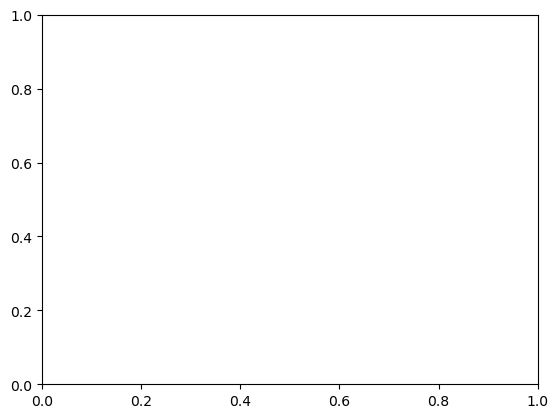

8-element Vector{Any}:
 [0.7428571428571429, 0.8118599115223674, 0.848578164518743, 0.8616172395451904, 0.8776484870123665, 0.8887795026443579, 0.8978966869639418, 0.9026075474553104, 0.9082470894003372, 0.9106516736306138, 0.9151201779502521]
 [0.65, 0.7009584500026047, 0.6998520018413577, 0.6716267108194873, 0.6751935558132323, 0.6700874619072356, 0.6774883918097061, 0.6946202177083346, 0.6808884890120221, 0.6765362212074165, 0.684018790325313]
 [0.7428571428571429, 0.8833531556347534, 0.9260964231754221, 0.9469817651906289, 0.9557357981749931, 0.9668794132920315, 0.969385611299, 0.9753448917056401, 0.9763240657957425, 0.976782382249136, 0.9772183182378991]
 [0.65, 0.702844121732406, 0.7684920947159519, 0.8307972329800863, 0.8898616688227458, 0.9415007560334454, 0.9759190899663487, 0.9866226200100787, 0.9912093301551408, 0.9954336202930832, 0.998096109663023]
 [0.625, 0.713547698427952, 0.735782379311844, 0.755547600729758, 0.7682419744791806, 0.7861935706202258, 0.8061506207663608, 

In [25]:
using PyPlot

fig, ax = subplots()

n_min = 7
n_max = 10
num_graphs = 1000 # total number of graphs to be created
num_samples = 2 # total number of samples taken from the array of graphs
p = 10 # total number of rounds to find the optimal angles
p_edge = 0.5 # probability for Erdos-Renyi graph
              # could be made random
              # a high p_edge also seems to make things faster
x = 0:p
#x = 1:6

#to_graph = mean_cost(kvertex_cover, n_min, n_max, num_graphs, num_samples, p, 
    #[mixer_ring, mixer_clique], [states, dicke_states]; p_edge=p_edge, optimal_ks=false)

to_graph = mean_cost(maxcut, n_min, n_max, num_graphs, num_samples, p, 
    [mixer_ring, mixer_clique], [dicke_states, states]; p_edge=p_edge, optimal_ks=false)

# Average the round-by-round performance over each instance
    # We start j at 2 because p = 0 corresponds to j = 1. 
    # j ends at p+1 because we add the initial approximation in the loop in the previous cell
    # Order from to_graph for each sample: ring+randomk, ring+dicke, clique+randomk, ring+dicke

testing graph #1 with size 10
The functions mixer_ring and mixer_clique were only configured for Dicke states. As a result, only states of Hamming weight k will be used.
yup!Inf
Inf
The functions mixer_ring and mixer_clique were only configured for Dicke states. As a result, only states of Hamming weight k will be used.
yup!6.283185307179586
6.283185307179586
testing graph #2 with size 8
The functions mixer_ring and mixer_clique were only configured for Dicke states. As a result, only states of Hamming weight k will be used.
yup!Inf
Inf
The functions mixer_ring and mixer_clique were only configured for Dicke states. As a result, only states of Hamming weight k will be used.
yup!6.283185307179586
6.283185307179586
testing graph #3 with size 9
The functions mixer_ring and mixer_clique were only configured for Dicke states. As a result, only states of Hamming weight k will be used.
yup!Inf
Inf
The functions mixer_ring and mixer_clique were only configured for Dicke states. As a result, on

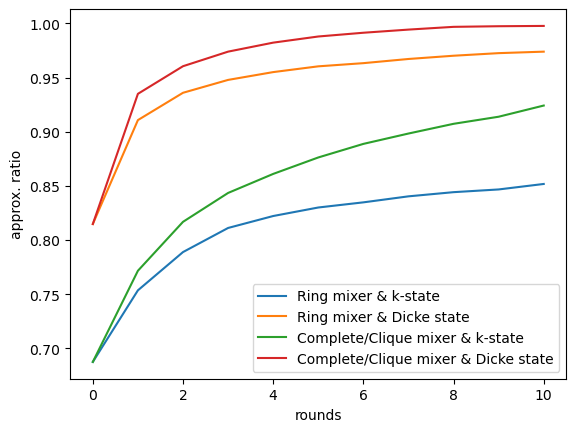

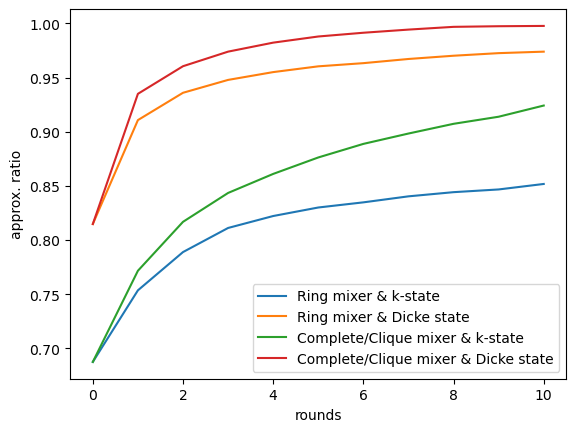

In [15]:
using PyPlot

fig, ax = subplots()

n_min = 7
n_max = 10
num_graphs = 1000 # total number of graphs to be created
num_samples = 10 # total number of samples taken from the array of graphs
p = 10 # total number of rounds to find the optimal angles
p_edge = 0.5 # probability for Erdos-Renyi graph
              # could be made random
              # a high p_edge also seems to make things faster
x = 0:p
#x = 1:6

#to_graph = mean_cost(kvertex_cover, n_min, n_max, num_graphs, num_samples, p, 
    #[mixer_ring, mixer_clique], [states, dicke_states]; p_edge=p_edge, optimal_ks=false)

to_graph = mean_cost(maxcut, n_min, n_max, num_graphs, num_samples, p, 
    [mixer_ring, mixer_clique], [states, dicke_states]; p_edge=p_edge, optimal_ks=false)

# Average the round-by-round performance over each instance
    # We start j at 2 because p = 0 corresponds to j = 1. 
    # j ends at p+1 because we add the initial approximation in the loop in the previous cell
    # Order from to_graph for each sample: ring+randomk, ring+dicke, clique+randomk, ring+dicke

y_randomk_ring = [mean([to_graph[i][j] for i in 1:4*num_samples:4]) for j in 1:p+1]
ax.plot(x, y_randomk_ring, label="Ring mixer & k-state")

y_dicke_ring = [mean([to_graph[i][j] for i in 2:4*num_samples:4]) for j in 1:p+1]
ax.plot(x, y_dicke_ring, label="Ring mixer & Dicke state")

y_randomk_clique = [mean([to_graph[i][j] for i in 3:4*num_samples:4]) for j in 1:p+1]
ax.plot(x, y_randomk_clique, label="Complete/Clique mixer & k-state")

y_dicke_clique = [mean([to_graph[i][j] for i in 4:4*num_samples:4]) for j in 1:p+1]
ax.plot(x, y_dicke_clique, label="Complete/Clique mixer & Dicke state")

ax.set_xlabel("rounds")
ax.set_ylabel("approx. ratio")
ax.legend()
gcf()

In [10]:
println(size(mixer_clique(4,2).vinv)) # for eigendecomposition (n, k) = 6 while 2^n = 16
println(mixer_clique(4,2).N) 
println(mixer_grover(4).N) 

(6, 6)
6
16


**Notes:**
* Increasing $p_{edge}$ leads to earlier convergence.
* Decreasing $n$ makes things faster (not surprisingly). I does not seem to do much for the convergence.
* Using the optimal $k$ leads to a far better result. That said, it is not what they seem to be doing in the papers.


In [13]:
using PyPlot
using Colors, ColorSchemes

fig, ax = subplots()

x = 1:p

#for i in 1:num_samples
for i in 10:10
    c1 = get(ColorSchemes.lajolla, i/num_samples)
    c2 = get(ColorSchemes.devon, i/num_samples)
    #c = ColorSchemes.lajolla100[1 + 5*(i-1)]
    #print(i)
    #println(c)
    y_randomk_complete = [vals_randomk_complete[i][j] for j in 1:p]
    #ax.plot(x, y_randomk_complete, label="Complete mixer & k-state", color=(red(c1), green(c1), blue(c1)))
    ax.plot(x, y_randomk_complete, color=(red(c1), green(c1), blue(c1)))

    #y_dicke_complete = [mean([vals_dicke_complete[i][j] for i in 1:num_samples]) for j in 1:p]
    #ax.plot(x, y_dicke_complete, label="Complete mixer & Dicke state", color=(red(c2), green(c2), blue(c2)))

    ax.set_xlabel("rounds")
    ax.set_ylabel("approx. ratio")
    ax.legend()
    gcf()
end



LoadError: UndefVarError: `vals_randomk_complete` not defined

In [12]:
g = graph_pop[rand(1:size(graph_pop)[1])] # pick one graph at random from the population of graphs
    n = size(g,1) # number of vertices in the graph
    
    obj_vals = [maxcut(g,x) for x in states(n)]
    obj_vals_dicke = [maxcut(g,x) for x in dicke_states(n,ceil(Int, n/2))]

println(n)
println(size(obj_vals))
println(obj_vals)
println(size(obj_vals_dicke))
println(obj_vals_dicke)
println(size(states(n)))

LoadError: UndefVarError: `graph_pop` not defined

## Back Up


In [ ]:

# A random state of n qubits is given
n = 3

for k = 0:n
    for x in states(n)
        if sum(x) == k
            push!(nk_state_array, x)
        end
    end
end
print(k_state_array)
    #k = sum(x)
    #print("Hamming weight k = ", k, "\n")
    #println(x)
#end
#print(2^n)
#print(size(states(n)))

n_test = 2
#n_state_array = Vector{Vector{Int64}}[]
n_state_array = []
for k = 0:n_test
    push!(n_state_array, khw_n_states(k, n_test))
    #println(n_state_array)
    #println(join(repr.(n_state_array)),", ")
end

#for state in n_state_array[1]
    #println(state)
#end
#println(n_state_array[[2,1]])
#@show n_state_array

In [ ]:
g = graph_pop[rand(1:size(graph_pop)[1])]
n = size(g,1)
println(n)
obj_vals = [maxcut(g,x) for x in states(n)]
    
# in the case of degenerate ground states with different k values, take the first one
k = union(sum.(filter(x->maxcut(g,x)==maximum(obj_vals), collect(states(n)))))[1]
#println(k)
    
# Dicke Initial State and Complete Graph Mixer
    
# Because Dicke states are sum of states for a specific k, our maxcut should reflect that.
obj_vals_dicke_complete = [maxcut(g,x) for x in dicke_states(n,k)]

dicke_states_array = []
#dicke_states_matrix = Array{Float64}(undef, 3, 3)
for state in dicke_states(n, k)
    #println(state)
    #dicke_states_matrix += state
    push!(dicke_states_array, state)
    #println(dicke_states_array)
    #dicke_states_sum += binomial(6, 4)*state
end

println(size(dicke_states_array))
dicke_states_lc = 1/sqrt(binomial(n, k))*sum(dicke_states_array, dims=1) # dims = 1 as we have a vector of vectors. 
                                                                         # so we need to do a row-by-row addition
print(dicke_states_lc)
# Create the Dicke state via a normalized linear combination of states with the same Hamming weight k
[maxcut(g,x) for x in dicke_states_lc]

The following is all bogus. Because, yes, technically a Dicke state is a linear combination of states but `maxcut` needs states that have $1$s and $0$s. Without that, the function will only give cuts of size $0$, as there aren't two "types" of vertices to choose from.


In [ ]:
# The better elements of this are from https://github.com/lanl/JuliQAOA.jl/blob/main/examples/maxcut_kconst.ipynb

n_min = 7
n_max = 10
num_graph = 1000 # total number of graphs to be created
num_samples = 100 # total number of samples taken from the array of graphs
p = 6 # total number of rounds to find the optimal angles

# Arrays for different combinations of mixing Hamiltonians and initial states:
vals_randomk_complete = [] 
vals_dicke_complete = []
vals_randomk_ring = []
vals_dicke_ring = []

graph_pop = graph_array(n_min, n_max, num_graph) # create a population of graphs
                                                 # quite intensive and may be unnecessary
for sample_idx in 1:num_samples
    g = graph_pop[rand(1:size(graph_pop)[1])] # pick one graph at random from the population of graphs
    n = size(g,1) # number of vertices in the graph
    println("testing graph #$sample_idx with size $n")
    obj_vals = [maxcut(g,x) for x in states(n)]
    k = union(sum.(filter(x->maxcut(g,x)==maximum(obj_vals), collect(states(n)))))[1]
    println(k)
        # Random-k Initial State and Complete Graph Mixer
    mixer_complete = mixer_clique(n,k)
    obj_vals_randomk_complete = obj_vals
    _, scores_randomk_complete = find_angles_bh(p, mixer_complete, obj_vals_randomk_complete; verbose=false)
    println("done")
end

In [ ]:
fig, ax = subplots()

x = 0:p
# average the round-by-round performance over each instance
y = [mean([vals_x[i][j] for i in 1:num_samples]) for j in 1:p+1]
ax.plot(x, y, label="X mixer, unconstrained")

y = [mean([vals_clique[i][j] for i in 1:num_samples]) for j in 1:p+1]
ax.plot(x, y, label="Clique mixer, constrained to Optimal k")

y = [mean([vals_ring[i][j] for i in 1:num_samples]) for j in 1:p+1]
ax.plot(x, y, label="Ring mixer, constrained to Optimal k")

ax.set_xlabel("rounds")
ax.set_ylabel("approx. ratio")
ax.legend()
gcf()

In [ ]:
n=3
Mixer{Grover}(states(n), 2^n, nothing, nothing, nothing, 2π, MixerLabel{Grover}(n=n))

In [ ]:
g = graph_pop[14]
n = size(g,1)
println(n)
obj_vals = [maxcut(g,x) for x in states(n)]
filter(x->maxcut(g,x)==maximum(obj_vals), collect(states(n)))
k = union(sum.(filter(x->maxcut(g,x)==maximum(obj_vals), collect(states(n)))))[1]
obj_vals_dicke = [maxcut(g,x) for x in dicke_states(n,k)]
maximum(obj_vals) - maximum(obj_vals_dicke)

In [ ]:
println(rand(2^n)/norm(rand(2^n)))
println("Mixer")
println(ones(ComplexF64, mixer_clique(n,k).N)/sqrt(mixer_clique(n,k).N))

for state in mixer_clique(n,k).feasible_states
    println(state)
end

for state in dicke_states(n,k)
    println("Dicke")
    println(state)
end

In [ ]:
using SparseArrays
using LinearAlgebra

H = spzeros(2^n, 2^n)
Is = [sparse(I, 2^(i-1), 2^(i-1)) for i in 1:2]
Is2 = [Matrix(I, 2^(i-1), 2^(i-1)) for i in 1:3]
println("Is this it?")
println(Is2)

In [ ]:
function guess_angles(old_angles)
    """
    From the initial set of functions in angle_finding.jl
    """ 
    if length(old_angles) == 0
        return rand(2)*2π
    else
        x0 = deepcopy(old_angles[end]) # BR: allows to copy old_angles[end] so that changing x0 does not change old_angles
        println("From deepcopy: $x0")
        rounds = Int(length(x0)/2)
        println(rounds)
        insert!(x0, rounds, x0[rounds]) # BR: insert!(a::Vector, index::Integer, item) -> insert item at index
        println(x0)
        push!(x0, x0[end]) # BR: end = keyword = last element
                           # BR: push! instead of append! as the two arguments are different types
        #println(x0)

        return x0
    end
end
old_angles = []
for i in 1:3
    if i == 1
        push!(old_angles, guess_angles(old_angles))
        println("From i = $i: $old_angles")
    else
        old_angles = guess_angles(old_angles)
        println("From i = $i: $old_angles")
    end
    #print(old_angles)


In [ ]:
using Optim
using Basinhopping
#using Enzyme
using LineSearches

import JuliQAOA: guess_angles # BR: needed because the function is not exported by default

function find_optimal_angles(sv, p, mixer, obj_vals, measure, max)
    """
    Determine the optimal angles by going through a grid of solutions with stepsize 0.1 pi
    """
    obj_vals_period = get_operator_period(obj_vals)
    if mixer.period < Inf && obj_vals_period < Inf
        max_angles = []
        #max_angles = zeros(2*p)
        max_bs = zeros(p)
        max_gs = zeros(p)
        max_exp_val = -Inf
        #max_testb = []
        #max_testg = []
        #for i in 1:p
            #append!(max_testb, "a")
            #append!(max_testg, "c")
        #end
        #max_test = []
        #test_array = []
        current_angles = []
        #current_bs = []
        #current_gs = []
        for round in 1:p
            #println(round)
            #println(mixer.period)
            #println(obj_vals_period)
            #println(p)
            #if round == 1
                #println("here")
            #end
            for b in 0:0.05*pi:mixer.period
                for g in 0:0.05*pi:obj_vals_period
                    #test_array = max_test
                    current_angles = max_angles
                    #test_array = max_test
                    insert!(current_angles, round, b)
                    insert!(current_angles, 2*round, g)
                    #insert!(test_array, round, "b")
                    #insert!(test_array, 2*round, "g")
                    #current_angles = [bs, gs]
                    #println(test_array)
                    if (max ? 1 : -1)*exp_value(sv, current_angles, mixer, obj_vals, measure) > max_exp_val
                    #if exp_value(sv, current_angles, mixer, obj_vals, measure) > max_exp_val
                    #max_exp_val = (max ? 1 : -1)*exp_value(sv, current_angles, mixer, obj_vals, measure)
                        max_exp_val = (max ? 1 : -1)*exp_value(sv, current_angles, mixer, obj_vals, measure)
                        println("A max has been found! We have round: $round, beta: $b, gamma: $g, expectation: $max_exp_val")
                        max_bs[round] = b
                        max_gs[round] = g
                        println(b,g)
                        #max_angles[round] = b
                        #max_angles[p+round] = g
                        #max_testb[round] = "b"
                        #max_testg[round] = "g"
                #else
                    #continue
                    end
                end
            end
            #println("here?")
            #max_test = reduce(vcat,[[b for b in max_testb], [g for g in max_testg]])
            max_angles = reduce(vcat,[[b for b in max_bs], [g for g in max_gs]]) # BR: flattens to a vector of form [bs, gs]
            #println(max_test)
        end
    else
        println("At least one operator has a period that could not be computed.")
    end
    return max_angles, max_exp_val
end


"""
    find_angles_bh(p, mixer, obj_vals; max=true, niter=100, file=nothing, verbose=true)

Find good angles up for the QAOA defined by `mixer`, `obj_vals` up to `p` rounds.

Uses an iterative, round-by-round angle finding algorithm that combines angle extrapolation
and [basinhopping](https://github.com/gamatos/Basinhopping.jl) to find high quality angles 
up to `p` rounds. See [this](https://arxiv.org/pdf/2202.00648.pdf) paper, section "Angle & 
Threshold Finding" for more details.

Optional arguments:
- `max=false`: determines whether the goal is to minimize or maximize `exp_value`
- `niter=100`: determines the number of basinhopping iterations
- `file=nothing`: save the resulting angles and expectation values in a plain text `file`
- `verbose=true`: print a running log of the angle finding results
- `random_start=false`: determines whether the initial set of angle values is random or not

Additional options:

    find_angles_bh(sv, p, mixer, obj_vals)

Specify the custom initial state ``|\\psi_0\\rangle`` = `sv`.

    find_angles_bh(p, mixer, obj_vals, measure)

Specify a cost function `measure` other than the default ``\\langle H_C \\rangle`` to
maximize/minimize.
    
    find_angles_bh(p, mixer, obj_vals, measure)

Specify both a custom initial state and observable to optimize. 

"""    
function find_angles_bh2(p::Int, mixer::Mixer, obj_vals, measure=obj_vals; kwargs...)
    sv = ones(ComplexF64, mixer.N)/sqrt(mixer.N)
    return find_angles_bh2(sv, p, mixer, obj_vals, measure; kwargs...)
end

function find_angles_bh2(sv::Vector, p::Int, mixer::Mixer, obj_vals::AbstractVector, measure::AbstractVector=obj_vals; max=true, niter=100, file=nothing, verbose=true, random_start=true)
    # add code to load results if file exists
    # add code to start skipping p if approximation ratio very close to 1
    angles = Vector{Vector{Float64}}()
    exp_vals = Vector{Float64}()
    opt = x0 -> optimize(x->(max ? -1 : 1)*exp_value(sv, x, mixer, obj_vals, measure), 
                   (G,x)->grad!(G, sv, x, mixer, obj_vals, measure; flip_sign=max), 
                   x0, 
                   BFGS(linesearch=LineSearches.BackTracking()))
    #if random_start == true #BR
        #x0 = guess_angles(angles)
    #else
        #x0 = find_optimal_angles(sv, mixer, obj_vals, measure, max)
    #end
    i = 1
    while i <= p
        if i == 1 && random_start == false
            println("this is round 1")
            new_angles, new_exp_val = find_optimal_angles(sv, mixer, obj_vals, measure, max)
            #x0 = new_angles
            #ret = basinhopping(opt, x0, BasinhoppingParams(niter=niter))
            #new_angles = clean_angles(Optim.minimizer(ret), mixer, obj_vals)
            #new_exp_val = (max ? -1 : 1)*minimum(ret)
            #ret = basinhopping(opt, x0, BasinhoppingParams(niter=niter))
            #new_exp_val = (max ? -1 : 1)*minimum(ret)
            println("The expectation value is $new_exp_val")
            println("The angles are $new_angles")
        else
            x0 = guess_angles(angles)
            #x0 = [0, pi]
            ret = basinhopping(opt, x0, BasinhoppingParams(niter=niter))
            #println(ret)
            new_angles = clean_angles(Optim.minimizer(ret), mixer, obj_vals)
            new_exp_val = (max ? -1 : 1)*minimum(ret) # BR: Optim.jl only does minimization so we need to multiply by -1
            println("The expectation value is $new_exp_val")
            println("The angles are $new_angles")
        end
        push!(angles, new_angles)
        push!(exp_vals, new_exp_val)
        if verbose
            println("done $i rounds, exp. value = $(round(new_exp_val, digits=5))")
        end
        i += 1
        if !isnothing(file)
            save_angle_finding_results(file, angles, exp_vals)
        end
    end
    return angles, exp_vals
end

In [ ]:
using Optim
using Basinhopping
#using Enzyme
using LineSearches

import JuliQAOA: guess_angles # BR: needed because the function is not exported by default

function find_optimal_angles(sv, p, mixer, obj_vals, measure, max)
    """
    Determine the optimal angles by going through a grid of solutions with stepsize 0.1 pi
    """
    obj_vals_period = get_operator_period(obj_vals)
    if mixer.period < Inf && obj_vals_period < Inf
        max_angles = []
        #max_angles = zeros(2*p)
        #max_bs = zeros(p)
        #max_gs = zeros(p)
        max_exp_val = -Inf
        #max_testb = []
        #max_testg = []
        #for i in 1:p
            #append!(max_testb, "a")
            #append!(max_testg, "c")
        #end
        #max_test = []
        #test_array = []
        current_angles = []
        #current_bs = []
        #current_gs = []
        for round in 1:p
            insert!(max_angles, round, 0) # for beta value
            insert!(max_angles, 2*round, 0)
            #println(round)
            #println(mixer.period)
            #println(obj_vals_period)
            #println(p)
            #if round == 1
                #println("here")
            #end
            current_angles = deepcopy(max_angles) # creates a new object with the values from max_angles
            println(current_angles)
            for b in 0:0.05*pi:mixer.period
                for g in 0:0.05*pi:obj_vals_period
                    #test_array = max_test
                    #current_angles = max_angles
                    current_angles[round] = b
                    current_angles[2*round] = g
                    #test_array = max_test
                    #insert!(current_angles, round, b)
                    #insert!(current_angles, 2*round, g)
                    #insert!(test_array, round, "b")
                    #insert!(test_array, 2*round, "g")
                    #current_angles = [bs, gs]
                    #println(test_array)
                    if (max ? 1 : -1)*exp_value(sv, current_angles, mixer, obj_vals, measure) > max_exp_val
                    #if exp_value(sv, current_angles, mixer, obj_vals, measure) > max_exp_val
                    #max_exp_val = (max ? 1 : -1)*exp_value(sv, current_angles, mixer, obj_vals, measure)
                        max_exp_val = (max ? 1 : -1)*exp_value(sv, current_angles, mixer, obj_vals, measure)
                        #println("A max has been found! We have round: $round, beta: $b, gamma: $g, expectation: $max_exp_val")
                        #max_bs[round] = b
                        #max_gs[round] = g
                        #println(b,g)
                        max_angles[round] = b
                        max_angles[2*round] = g
                        #max_testb[round] = "b"
                        #max_testg[round] = "g"
                #else
                    #continue
                    end
                end
            end
            #println("here?")
            #max_test = reduce(vcat,[[b for b in max_testb], [g for g in max_testg]])
            #max_angles = reduce(vcat,[[b for b in max_bs], [g for g in max_gs]]) # BR: flattens to a vector of form [bs, gs]
            #println(max_test)
        end
    else
        println("At least one operator has a period that could not be computed.")
    end
    return max_angles, max_exp_val
end


"""
    find_angles_bh(p, mixer, obj_vals; max=true, niter=100, file=nothing, verbose=true)

Find good angles up for the QAOA defined by `mixer`, `obj_vals` up to `p` rounds.

Uses an iterative, round-by-round angle finding algorithm that combines angle extrapolation
and [basinhopping](https://github.com/gamatos/Basinhopping.jl) to find high quality angles 
up to `p` rounds. See [this](https://arxiv.org/pdf/2202.00648.pdf) paper, section "Angle & 
Threshold Finding" for more details.

Optional arguments:
- `max=false`: determines whether the goal is to minimize or maximize `exp_value`
- `niter=100`: determines the number of basinhopping iterations
- `file=nothing`: save the resulting angles and expectation values in a plain text `file`
- `verbose=true`: print a running log of the angle finding results
- `random_start=false`: determines whether the initial set of angle values is random or not

Additional options:

    find_angles_bh(sv, p, mixer, obj_vals)

Specify the custom initial state ``|\\psi_0\\rangle`` = `sv`.

    find_angles_bh(p, mixer, obj_vals, measure)

Specify a cost function `measure` other than the default ``\\langle H_C \\rangle`` to
maximize/minimize.
    
    find_angles_bh(p, mixer, obj_vals, measure)

Specify both a custom initial state and observable to optimize. 

"""    
function find_angles_bh2(p::Int, mixer::Mixer, obj_vals, measure=obj_vals; kwargs...)
    sv = ones(ComplexF64, mixer.N)/sqrt(mixer.N)
    return find_angles_bh2(sv, p, mixer, obj_vals, measure; kwargs...)
end

function find_angles_bh2(sv::Vector, p::Int, mixer::Mixer, obj_vals::AbstractVector, measure::AbstractVector=obj_vals; max=true, niter=100, file=nothing, verbose=true, random_start=true)
    # add code to load results if file exists
    # add code to start skipping p if approximation ratio very close to 1
    angles = Vector{Vector{Float64}}()
    exp_vals = Vector{Float64}()
    opt = x0 -> optimize(x->(max ? -1 : 1)*exp_value(sv, x, mixer, obj_vals, measure), 
                   (G,x)->grad!(G, sv, x, mixer, obj_vals, measure; flip_sign=max), 
                   x0, 
                   BFGS(linesearch=LineSearches.BackTracking()))
    #if random_start == true #BR
        #x0 = guess_angles(angles)
    #else
        #x0 = find_optimal_angles(sv, mixer, obj_vals, measure, max)
    #end
    i = 1
    while i <= p
        if i == 1 && random_start == false
            println("this is round 1")
            new_angles, new_exp_val = find_optimal_angles(sv, mixer, obj_vals, measure, max)
            #x0 = new_angles
            #ret = basinhopping(opt, x0, BasinhoppingParams(niter=niter))
            #new_angles = clean_angles(Optim.minimizer(ret), mixer, obj_vals)
            #new_exp_val = (max ? -1 : 1)*minimum(ret)
            #ret = basinhopping(opt, x0, BasinhoppingParams(niter=niter))
            #new_exp_val = (max ? -1 : 1)*minimum(ret)
            println("The expectation value is $new_exp_val")
            println("The angles are $new_angles")
        else
            x0 = guess_angles(angles)
            #x0 = [0, pi]
            ret = basinhopping(opt, x0, BasinhoppingParams(niter=niter))
            #println(ret)
            new_angles = clean_angles(Optim.minimizer(ret), mixer, obj_vals)
            new_exp_val = (max ? -1 : 1)*minimum(ret) # BR: Optim.jl only does minimization so we need to multiply by -1
            println("The expectation value is $new_exp_val")
            println("The angles are $new_angles")
        end
        push!(angles, new_angles)
        push!(exp_vals, new_exp_val)
        if verbose
            println("done $i rounds, exp. value = $(round(new_exp_val, digits=5))")
        end
        i += 1
        if !isnothing(file)
            save_angle_finding_results(file, angles, exp_vals)
        end
    end
    return angles, exp_vals
end

In [ ]:
# The better elements of this are from https://github.com/lanl/JuliQAOA.jl/blob/main/examples/maxcut_kconst.ipynb

n_min = 8
n_max = 8
n = n_min
num_graph = 1000 # total number of graphs to be created
num_samples = 10 # total number of samples taken from the array of graphs
p = 10 # total number of rounds to find the optimal angles
p_edge = 0.5 # probability for Erdos-Renyi graph
              # could be made random
              # a high p_edge also seems to make things faster

# Arrays for different combinations of mixing Hamiltonians and initial states:
vals_randomk_complete = [] 
vals_dicke_complete = []
vals_randomk_ring = []
vals_dicke_ring = []

graph_pop = graph_array(n_min, n_max, num_graph, p_edge) # create a population of graphs
                                                         # may be unnecessary

# Loop over samples:
for sample_idx in 1:num_samples
    #g = graph_pop[rand(1:size(graph_pop)[1])] # pick one graph at random from the population of graphs
    #n = size(g,1) # number of vertices in the graph
    g = erdos_renyi(n, 0.5)
    #n = size(g,1) # number of vertices in the graph
    #println(ones(ComplexF64, n)/sqrt(n))
    println("testing graph #$sample_idx with size $n")
    
    #obj_vals = [maxcut(g,x) for x in states(n)]
    obj_vals = [kvertex_cover(g,x) for x in states(n)]
    
    # in the case of degenerate ground states with different k values, take the first one
    # BR: Essentially a neater way to implement find_optimal_k()
        # collect(states(n)): provides a vector whose elements are states(n)
        # x -> maxcut(g,x) == maximum(obj_vals): anonymous function that takes x as an argument
            # and checks whether maxcut(g,x) == maximum(obj_vals)
        # filter(x->maxcut(g,x)==maximum(obj_vals), collect(states(n)): filters states in collect(states(n))
            # that are such that maxcut(g,x)==maximum(obj_vals)
            # the typical syntax is filter(f, a) and returns a copy of a in which the elements for which f is
                # not satisfied are removed.
        # sum.(filter(x->maxcut(g,x)==maximum(obj_vals), collect(states(n)))): the "dot" syntax corresponds to 
            # broadcasting. I allows one to perform the sum of all elements in the individual vectors, thereby 
            # giving the a vector of Hamming weights
    k = union(sum.(filter(x->kvertex_cover(g,x)==maximum(obj_vals), collect(states(n)))))[1] # gives a vector of different 
                                                                                      # Hamming weights.
    #k = floor(Int, n/2)
    #println(k)

    # Random-k Initial State and Complete Graph Mixer
    mixer_complete = mixer_clique(n,k)
    #println(ones(ComplexF64, mixer_clique(n,k).N)/sqrt(mixer_clique(n,k).N))
    obj_vals_randomk_complete = obj_vals
    _, scores_randomk_complete = find_angles_bh2(p, mixer_complete, obj_vals_randomk_complete; verbose=false, random_start=false)
    
    # Dicke Initial State and Complete Graph Mixer
    #obj_vals_dicke_complete = fill(maximum([maxcut(g,x) for x in dicke_states(n,k)]), size(khw_n_states(k,n))) 
    #psi0test = make_dicke_states_array(n,k)[1]/sqrt(k)
    #println(psi0test)
    obj_vals_dicke_complete = [kvertex_cover(g,x) for x in dicke_states(n,k)]
    #println(obj_vals_dicke_complete)
    #_, scores_dicke_complete = find_angles_bh(ones(ComplexF64, mixer_complete.N)/sqrt(mixer_complete.N), p, mixer_complete, obj_vals_dicke_complete; verbose=false)
    _, scores_dicke_complete = find_angles_bh2(p, mixer_complete, obj_vals_dicke_complete; niter=100, verbose=false, random_start=false)
        
    # let's add the approximation ratio that each QAOA begins at
    prepend!(scores_randomk_complete, mean(obj_vals_randomk_complete))
    prepend!(scores_dicke_complete, mean(obj_vals_dicke_complete))
    
    # convert to approximation ratio so that each graph contributes equally to the mean
    push!(vals_randomk_complete, scores_randomk_complete / maximum(obj_vals))
    push!(vals_dicke_complete, scores_dicke_complete / maximum(obj_vals))
    
    # Random-k Initial State and Ring Mixer
    # Dicke Initial State and Ring Mixer
    
    # Random-k Initial State and Complete Graph Mixer
    #obj_vals = [maxcut(g,x) for x in states(n)] 
        
    # CHECK THE NOTION OF DEGENERACY  
end


In [ ]:
function test_default(k=2)
    if defaults(k)
        print(k)
    else
        print(k)
    end
end

test_default()

In [ ]:
#function mean_max_k_vertex(n_min::Int, n_max::Int, num_graph::Int, num_samples::Int, mixer::Mixer, psi0::Function)
n = 3
g = erdos_renyi(n, 0.5)
intial_state = states(3)
function test_function_pass(f::Function, state_fc::Function)
    for x in state_fc(n)
        println(x)
    end
    return [f(g,x) for x in state_fc(n)]
end
test_function_pass(kvertex_cover, states)
#for state in states(3)
    #println(state)
#end
#print(states(3))


function mean_cost_test(cost::Function, n::Int, psi0::AbstractArray{Function}; p_edge=0.5, k=nothing)
    #if isassigned(k) == false
        #println("this works")
        #k = floor(Int, n/2)
    #else
        #print("Custom k used.")
    #end
    if k == nothing
        k=1
    end
    for i in 1:length(psi0)
        println(i)
        println(psi0[i])
        if psi0[i] == mixer_clique
            println("right")
            println(psi0[i](n,k))
            #println([cost(g,x) for x in psi0[i](n,k)])
        elseif psi0[i] == mixer_ring
            println("left")
            println(psi0[i](n,k))
        else
            println("this type of initial state needs to be implemented in mean_cost.")
        end
    end
end

#mean_cost(kvertex_cover, 3, [states, dicke_states])
mean_cost_test(kvertex_cover, 4, [mixer_clique, mixer_ring])

In [ ]:
# The better elements of this are from https://github.com/lanl/JuliQAOA.jl/blob/main/examples/maxcut_kconst.ipynb
g = erdos_renyi(4, 0.5)
n = size(g,1) # number of vertices in the graph
    
obj_vals = [kvertex_cover(g,x) for x in states(n)]
println(obj_vals)
obj_vals_const = [kvertex_cover(g,x) for x in dicke_states(n,floor(Int,n/2))]
println(obj_vals_const)